In [55]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf


In [41]:
RAW_DIR = "/content/raw_images"
GRAY_DIR = "/content/processed/grayscale"
DENOISE_DIR = "/content/processed/denoised"
EDGE_DIR = "/content/processed/edges"
BAND_DIR = "/content/processed/enhanced_bands"

os.makedirs("/content/raw_images", exist_ok=True)

for d in [GRAY_DIR, DENOISE_DIR, EDGE_DIR, BAND_DIR]:
    os.makedirs(d, exist_ok=True)


In [42]:
print("Raw images:")
print(os.listdir(RAW_DIR))


Raw images:
['R1843-2.JPG', 'S13322-2.JPG', 'R2373-2.JPG', 'S2486-4.JPG', 'S13781-1.JPG', 'R1408-1.JPG', 'S13322-1.JPG', 'C496-4.JPG', 'C903-1.JPG', 'R2167-4.JPG', 'S14025-3.JPG', 'C50-4.JPG', 'R2982-4.JPG', 'title3.jpg', 'C133-1.JPG', 'C950-1.JPG', 'R712-2.JPG', 'R682-3.JPG', 'C261-3.JPG', 'R3361-3.JPG', 'C732-1.JPG', 'S13471-2.JPG', 'C732-4.JPG', 'S11148-1.JPG', 'R1962-3.JPG', 'C2540-4.JPG', 'S1792-1.JPG', 'R2676-4.JPG', 'R216-2.JPG', 'C975-1.JPG', 'R2242-2.JPG', 'C122(22-28).JPG', 'C50-2.JPG', 'S10324-1.JPG', 'C8-2.JPG', 'R2247-1.JPG', 'S974-1.JPG', 'C496-1.JPG', 'C39-3.JPG', 'C169-3.JPG', 'C595-1.JPG', 'S13781-3.JPG', 'S10925-2.JPG', 'S1974-1.JPG', 'R1408-4.JPG', 'R3261-1.JPG', 'S10324-4.JPG', 'C506-3.JPG', 'R3279-4.JPG', 'S1792-2.JPG', 'C169-4.JPG', 'Oslash2.jpg', 'S2539-4.JPG', 'C10295-1.JPG', 'R1382-1.JPG', 'R374-1.JPG', 'S14082-2.JPG', 'R2628-1.JPG', 'R1553-2.JPG', 'S11214-1.JPG', 'S2486-1.JPG', 'R2414-3.JPG', 'C496-2.JPG', 'R63-1.JPG', 'R3166-2.JPG', 'R2401-4.JPG', 'S1511-3.JP

In [43]:
valid_ext = (".jpg", ".jpeg", ".png")

for img_name in os.listdir(RAW_DIR):
    if not img_name.lower().endswith(valid_ext):
        continue

    img_path = os.path.join(RAW_DIR, img_name)
    img = cv2.imread(img_path)

    if img is None:
        print("Skipping unreadable:", img_name)
        continue

    # 1️⃣ Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(GRAY_DIR, img_name), gray)

    # 2️⃣ Denoise
    denoised = cv2.GaussianBlur(gray, (5,5), 0)
    cv2.imwrite(os.path.join(DENOISE_DIR, img_name), denoised)

    # 3️⃣ Edge detection
    edges = cv2.Canny(denoised, 50, 150)
    cv2.imwrite(os.path.join(EDGE_DIR, img_name), edges)

    # 4️⃣ Band enhancement (thresholding)

    # Estimate background using large kernel
    bg_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,25))
    background = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, bg_kernel)

    # Subtract background
    band_only = cv2.subtract(denoised, background)

    # Normalize contrast
    band_only = cv2.normalize(band_only, None, 0, 255, cv2.NORM_MINMAX)

    # Adaptive threshold on band-only image
    bands = cv2.adaptiveThreshold(
        band_only,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        15,
        3
    )

    # Clean small noise
    small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    bands = cv2.morphologyEx(bands, cv2.MORPH_OPEN, small_kernel)

    cv2.imwrite(os.path.join(BAND_DIR, img_name), bands)


print("✅ Image processing completed")

Skipping unreadable: C198-2.JPG
✅ Image processing completed


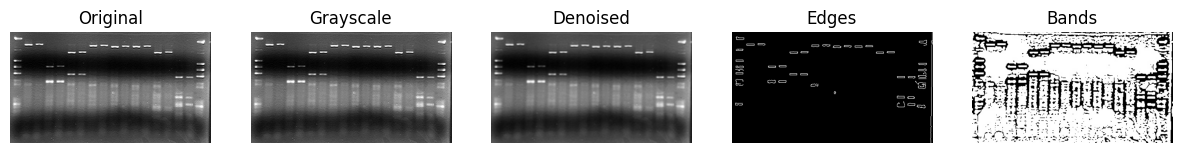

In [44]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_list = os.listdir(RAW_DIR)

if not img_list:
    print(f"Error: No images found in {RAW_DIR}. Please upload images to this directory first.")
else:
    # The original comment said 'first image', but accessed index 2. This now correctly picks the first image.
    img_name = img_list[0]

    paths = {
        "Original": os.path.join(RAW_DIR, img_name),
        "Grayscale": os.path.join(GRAY_DIR, img_name),
        "Denoised": os.path.join(DENOISE_DIR, img_name),
        "Edges": os.path.join(EDGE_DIR, img_name),
        "Bands": os.path.join(BAND_DIR, img_name)
    }

    plt.figure(figsize=(15,5))

    i = 1
    for title, path in paths.items():
        if not os.path.exists(path):
            print(f"Warning: Image for '{title}' not found at {path}. Displaying a blank placeholder.")
            img = np.zeros((100, 100), dtype=np.uint8) # Placeholder for missing image
            title = f"{title} (Missing)"
        else:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read image for '{title}' at {path}. Displaying a blank placeholder.")
                img = np.zeros((100, 100), dtype=np.uint8) # Placeholder if image is unreadable
                title = f"{title} (Unreadable)"

        plt.subplot(1,5,i)
        plt.imshow(img, cmap="gray")
        plt.title(title)
        plt.axis("off")
        i += 1

    plt.show()


In [45]:
!wget -q https://storage.googleapis.com/sctp-colab/images.zip -O /tmp/images.zip
!unzip -q /tmp/images.zip -d /content/raw_images
print(f"Downloaded {len(os.listdir(RAW_DIR))} images to {RAW_DIR}")

[/tmp/images.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /tmp/images.zip or
        /tmp/images.zip.zip, and cannot find /tmp/images.zip.ZIP, period.
Downloaded 538 images to /content/raw_images


In [46]:
valid_ext = (".jpg", ".jpeg", ".png")

for img_name in os.listdir(RAW_DIR):
    if not img_name.lower().endswith(valid_ext):
        continue

    img_path = os.path.join(RAW_DIR, img_name)
    img = cv2.imread(img_path)

    if img is None:
        print("Skipping unreadable:", img_name)
        continue

    # 1️⃣ Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(GRAY_DIR, img_name), gray)

    # 2️⃣ Denoise
    denoised = cv2.GaussianBlur(gray, (5,5), 0)
    cv2.imwrite(os.path.join(DENOISE_DIR, img_name), denoised)

    # 3️⃣ Edge detection
    edges = cv2.Canny(denoised, 50, 150)
    cv2.imwrite(os.path.join(EDGE_DIR, img_name), edges)

    # 4️⃣ Band enhancement (thresholding)

    # Estimate background using large kernel
    bg_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,25))
    background = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, bg_kernel)

    # Subtract background
    band_only = cv2.subtract(denoised, background)

    # Normalize contrast
    band_only = cv2.normalize(band_only, None, 0, 255, cv2.NORM_MINMAX)

    # Adaptive threshold on band-only image
    bands = cv2.adaptiveThreshold(
        band_only,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        15,
        3
    )

    # Clean small noise
    small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    bands = cv2.morphologyEx(bands, cv2.MORPH_OPEN, small_kernel)

    cv2.imwrite(os.path.join(BAND_DIR, img_name), bands)


print("✅ Image processing completed")

Skipping unreadable: C198-2.JPG
✅ Image processing completed


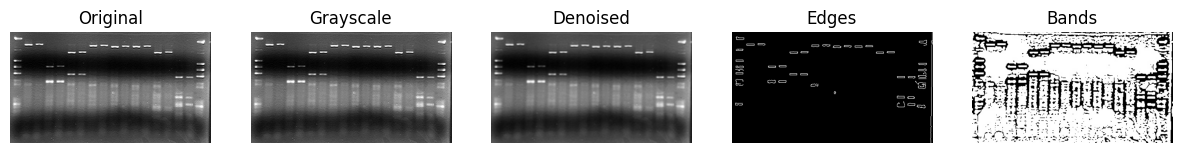

In [47]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_list = os.listdir(RAW_DIR)

if not img_list:
    print(f"Error: No images found in {RAW_DIR}. Please upload images to this directory first.")
else:
    # The original comment said 'first image', but accessed index 2. This now correctly picks the first image.
    img_name = img_list[0]

    paths = {
        "Original": os.path.join(RAW_DIR, img_name),
        "Grayscale": os.path.join(GRAY_DIR, img_name),
        "Denoised": os.path.join(DENOISE_DIR, img_name),
        "Edges": os.path.join(EDGE_DIR, img_name),
        "Bands": os.path.join(BAND_DIR, img_name)
    }

    plt.figure(figsize=(15,5))

    i = 1
    for title, path in paths.items():
        if not os.path.exists(path):
            print(f"Warning: Image for '{title}' not found at {path}. Displaying a blank placeholder.")
            img = np.zeros((100, 100), dtype=np.uint8) # Placeholder for missing image
            title = f"{title} (Missing)"
        else:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read image for '{title}' at {path}. Displaying a blank placeholder.")
                img = np.zeros((100, 100), dtype=np.uint8) # Placeholder if image is unreadable
                title = f"{title} (Unreadable)"

        plt.subplot(1,5,i)
        plt.imshow(img, cmap="gray")
        plt.title(title)
        plt.axis("off")
        i += 1

    plt.show()


In [48]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = 128
X = []

for img_name in os.listdir(BAND_DIR):
    img_path = os.path.join(BAND_DIR, img_name)
    img = load_img(
        img_path,
        color_mode="grayscale",
        target_size=(IMG_SIZE, IMG_SIZE)
    )
    img = img_to_array(img) / 255.0
    X.append(img)

X = np.array(X)
print("DL input shape:", X.shape)


DL input shape: (537, 128, 128, 1)


In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

x = Conv2D(32, (3,3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2,2), padding="same")(x)
x = Conv2D(16, (3,3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2,2), padding="same")(x)

x = Conv2D(16, (3,3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2,2))(x)

decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
autoencoder.fit(
    X, X,
    epochs=20,
    batch_size=16,
    validation_split=0.1
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 608ms/step - loss: 0.1605 - val_loss: 0.1120
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - loss: 0.1047 - val_loss: 0.1028
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 644ms/step - loss: 0.0944 - val_loss: 0.0926
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - loss: 0.0863 - val_loss: 0.0835
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 588ms/step - loss: 0.0805 - val_loss: 0.0750
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 592ms/step - loss: 0.0730 - val_loss: 0.0713
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 603ms/step - loss: 0.0682 - val_loss: 0.0683
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 609ms/step - loss: 0.0642 - val_loss: 0.0656
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 639ms/step - loss: 0.0629 - val_loss: 0.0628
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 631ms/step - loss: 0.0608 - val_loss: 0.0600
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - loss: 0.0561 - val_loss: 0.0593
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21

In [51]:
RECON_DIR = "/content/results/reconstructions"
HEAT_DIR = "/content/results/heatmaps"

os.makedirs(RECON_DIR, exist_ok=True)
os.makedirs(HEAT_DIR, exist_ok=True)

recon = autoencoder.predict(X)

for i in range(len(X)):
    diff = np.abs(X[i] - recon[i])

    plt.imsave(
        f"{RECON_DIR}/recon_{i}.png",
        recon[i].reshape(IMG_SIZE, IMG_SIZE),
        cmap="gray"
    )

    plt.imsave(
        f"{HEAT_DIR}/heatmap_{i}.png",
        diff.reshape(IMG_SIZE, IMG_SIZE),
        cmap="hot"
    )

print("✅ Reconstruction & heatmaps saved")


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step
✅ Reconstruction & heatmaps saved


In [52]:
autoencoder.save("/content/model/autoencoder.h5")
print("Model saved successfully")


Model saved successfully


In [53]:
import os
os.listdir("/content/model")


['autoencoder.h5']